In [1]:
def parse_group(file, baseline = False):
    line = file.readline()
    while("config" not in line):
        if(line == ""):
            return None
        line = file.readline()
    

    before_acc = file.readline()
    setting = file.readline()
    setting = setting.replace("{", "").replace("}", "")
    entries = setting.split(",")
    name = entries[0].split(":")[1].replace("'","").strip()
    # print(f"{entries[5]}, {entries[7]}")
    # tc = "[]" in entries[5]
    # tw = "[]" in entries[7]
    tc = (setting.find("'tce': []") == -1)
    tw = (setting.find("'twe': []") == -1)

    line = file.readline()
    swa = "None"
    acc_list = []
    if("acc" in line):
        next_layer = False
        acc_list.append(line.split(":")[1].strip())
        line = file.readline()
        while("swa" not in line):
            acc_list.append(line.split(":")[1].strip())
            line = file.readline()
        swa = line.split(":")[1].strip()
    else:
        next_layer = True
    
    return [name, tw, tc, acc_list, swa, next_layer]


def parse(file):
    full_list = []
    ret = parse_group(file)
    while(ret):
        tag = None
        if(ret[5]):
            tag = "PA to " + ret[0]
            ret = parse_group(file)
            last_tc = ret[2]

        else:
            if(ret[2] != last_tc):
                if(ret[1]):
                    tag = "AT to weight"
                elif(ret[2]):
                    tag = "AT to coef"
                else:
                    assert(False and "tc tw confilict")
            else:
                if(ret[1]):
                    tag = "keep on weight"
                elif(ret[2]):
                    tag = "keep on coef"
                else:
                    assert(False and "tc tw confilict")
            last_tc = ret[2]

        start = True
        for acc in ret[3]:
            if(start):
                start = False
                full_list.append([acc, tag])
            else:
                full_list.append([acc, ""])
        if(ret[4] != "None"):
            full_list.append([ret[4], "swa"])
        ret = parse_group(file)
    return full_list

def parse_baseline(file):
    full_list = []
    ret = parse_group(file)
    while(ret):
        tag = None
        start = True
        for acc in ret[3]:
                full_list.append([acc, ""])
        if(ret[4] != "None"):
            full_list.append([ret[4], "swa"])
        ret = parse_group(file)
    return full_list

In [4]:
file_baseline = open("/home/jianming/work/SmartPAF_Prj/SmartPAF/expriments/fig9/PR_AT_2f12g1-baseline.log")
file_baseline = parse_baseline(file_baseline)
file_smartPAF = open("/home/jianming/work/SmartPAF_Prj/SmartPAF/expriments/fig9/PR_AT_2f12g1.log")
file_smartPAF = parse(file_smartPAF)

In [20]:
value_smartPAF = [ ]
value_baseline = [ ]
for idx, entry in enumerate(file_smartPAF):
    value_smartPAF.append(float(entry[0]))

for idx, entry in enumerate(file_baseline):
    value_baseline.append(float(entry[0]))

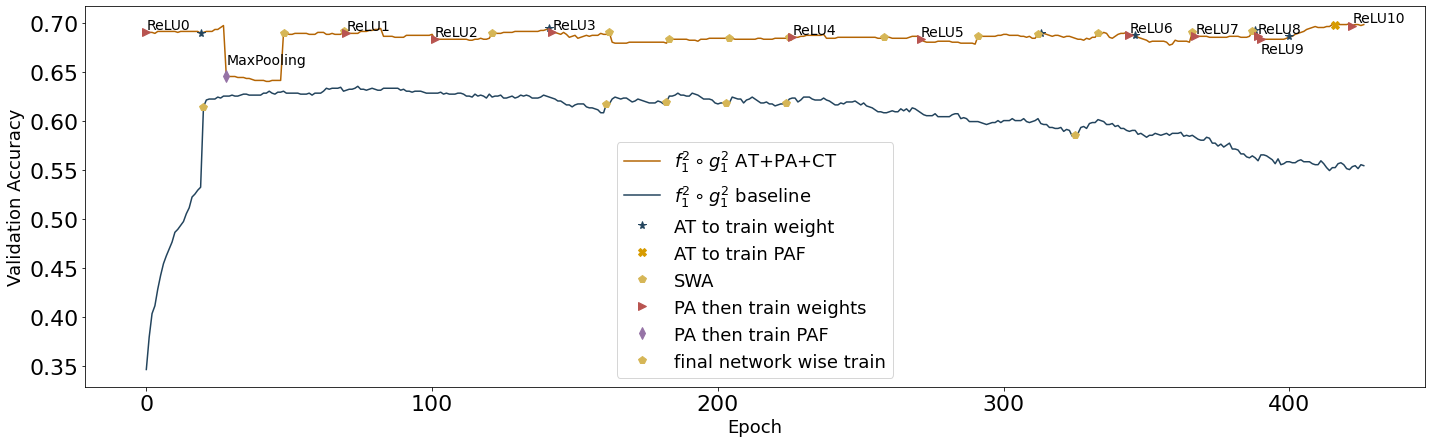

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

shape_list = ["o", "*", "X", "p", ">", "d", "s", "H", "<"]
legend_list = ["A", "B", "C", "D", "E", "F", "G", "H"]
color_list = ["#B46504", "#23445D", "#D79B00", "#D6B656", "#B85450", "#9673A6", "#6C8EBF", "#82B366"]

x_smartpaf = [i for i in range(len(value_smartPAF))]
x_baseline = [i for i in range(len(value_baseline))]
# create data
fig = plt.figure(figsize=[24, 7])
ax = plt.subplot(111)

ax.plot(x_smartpaf, value_smartPAF, marker=shape_list[0], markerfacecolor=color_list[0], markersize=0, color=color_list[0], linewidth=1.5)
ax.plot(x_smartpaf, value_baseline[:len(x_smartpaf)], marker=shape_list[1], markerfacecolor=color_list[1], markersize=0, color=color_list[1], linewidth=1.5)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

global_relu_index = 0
SWA_list = [[], []]
AT_weights_list = [[], []]
AT_PAF_list = [[], []]
PA_weights_list = [[], [], []]
PA_PAF_list = [[], [], []]
baseline_SWA_list = [[], []]

maximal_smartpaf_acc = 0
for idx, entry in enumerate(file_smartPAF):
    if maximal_smartpaf_acc < float(entry[0]):
        maximal_smartpaf_acc = float(entry[0])
    if "AT" in entry[1] and "weight" in entry[1]:
        AT_weights_list[0].append(idx)
        AT_weights_list[1].append(float(entry[0]))
    elif "AT" in entry[1] and "coef" in entry[1]:
        AT_PAF_list[0].append(idx)
        AT_PAF_list[1].append(float(entry[0]))
    elif entry[1] == "swa":
        SWA_list[0].append(idx)
        SWA_list[1].append(float(entry[0]))
    elif "PA" in entry[1] and "relu" in entry[1]:
        PA_weights_list[0].append(idx)
        PA_weights_list[1].append(float(entry[0]))
        PA_weights_list[2].append(f"ReLU{global_relu_index}")
        global_relu_index+=1
    elif "PA" in entry[1] and "maxpool" in entry[1]:
        PA_PAF_list[0].append(idx)
        PA_PAF_list[1].append(float(entry[0]))
        PA_PAF_list[2].append("MaxPooling")

minimal_baseline_acc = 0.99
for idx, entry in enumerate(file_baseline):
    if minimal_baseline_acc > float(entry[0]):
        minimal_baseline_acc = float(entry[0])
    if entry[1] == "swa":
        baseline_SWA_list[0].append(idx)
        baseline_SWA_list[1].append(float(entry[0]))

ax.plot(AT_weights_list[0], AT_weights_list[1], marker=shape_list[1], markerfacecolor=color_list[1], markersize=8, color=color_list[1], linewidth=0)
ax.plot(AT_PAF_list[0], AT_PAF_list[1], marker=shape_list[2], markerfacecolor=color_list[2], markersize=8, color=color_list[2], linewidth=0)
ax.plot(SWA_list[0], SWA_list[1], marker=shape_list[3], markerfacecolor=color_list[3], markersize=8, color=color_list[3], linewidth=0)
ax.plot(PA_weights_list[0], PA_weights_list[1], marker=shape_list[4], markerfacecolor=color_list[4], markersize=8, color=color_list[4], linewidth=0)
ax.plot(PA_PAF_list[0], PA_PAF_list[1], marker=shape_list[5], markerfacecolor=color_list[5], markersize=8, color=color_list[5], linewidth=0)

ax.plot(baseline_SWA_list[0][:6], baseline_SWA_list[1][:6], marker=shape_list[3], markerfacecolor=color_list[3], markersize=8, color=color_list[3], linewidth=0)

# look mess up
for idx, entry in enumerate(PA_weights_list[0]):
    if entry != "":
        if PA_weights_list[2][idx] == "ReLU9":
            plt.text(entry, PA_weights_list[1][idx]*0.98, PA_weights_list[2][idx], fontsize=14)
        else:
            plt.text(entry, PA_weights_list[1][idx]*1.005, PA_weights_list[2][idx], fontsize=14)


for idx, entry in enumerate(PA_PAF_list[0]):
    if entry != "":
        plt.text(entry, PA_PAF_list[1][idx]*1.02, PA_PAF_list[2][idx], fontsize=14)

# plt.ylim(minimal_baseline_acc, maximal_smartpaf_acc)
plt.ylabel("Validation Accuracy", fontsize=SMALL_SIZE)
plt.xlabel("Epoch", fontsize=SMALL_SIZE)

plt.legend([r"$f_1^2 \circ g_1^2$ AT+PA+CT", r"$f_1^2 \circ g_1^2$ baseline", r"AT to train weight", r"AT to train PAF", r"SWA", r"PA then train weights", r"PA then train PAF", r"final network wise train"], fontsize=SMALL_SIZE)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.savefig(r'convergence_curve.pdf', bbox_inches="tight", transparent=True) 
plt.show()